In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import seaborn as sns
import sklearn
import imblearn
import matplotlib.pyplot as plt
import time
import sklearn.metrics as m
import xgboost as xgb
#import minmaxscaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder



In [2]:
#Load Data
# datasets\target_model\CICIDS2018\target_model_CICIDS2018data.csv
train = pd.read_csv('../datasets/target_model/CICIDS2018/train.csv')
val = pd.read_csv('../datasets/target_model/CICIDS2018/val.csv')
test = pd.read_csv('../datasets/target_model/CICIDS2018/test.csv')

In [3]:
def Preprocess_GAN(train, label):
    # min max standardization
    # 創建一個MinMaxScaler對象
    # scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler = RobustScaler()

    # 選擇所有數值型列，並移除"BwdPSHFlags"
    numeric_columns = list(train.select_dtypes(include=['int', "float"]).columns)
    numeric_columns.remove("BwdPSHFlags")
    numeric_columns.remove(label)
    
    # 對每一個數值型列進行縮放
    for c in numeric_columns:
        train[c] = scaler.fit_transform(train[[c]])

    # get the true label of the train set
    true_label = train[label]

    del train[label]

    return train, true_label

[Text(0, 0, '10487'), Text(0, 0, '1166'), Text(0, 0, '2914')]

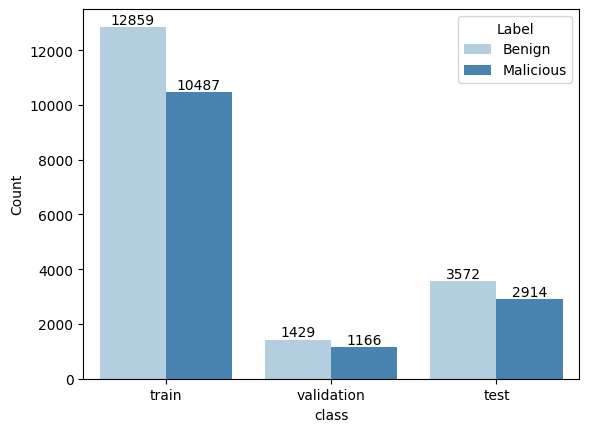

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train_distribution = train.value_counts('Label')
train_distribution = train_distribution.reset_index()
train_distribution["class"] = "train"

val_distribution = val.value_counts('Label')
val_distribution = val_distribution.reset_index()
val_distribution["class"] = "validation"

test_distribution = test.value_counts('Label')
test_distribution = test_distribution.reset_index()
test_distribution["class"] = "test"

total_distribution = pd.concat([train_distribution, val_distribution, test_distribution])

total_distribution.columns = ["Label", "Count", "class"]
grade_map = {
    0: "Benign",
    1: "Malicious"}
total_distribution["Label"] = total_distribution["Label"].map(grade_map)

total_distribution
ax = sns.barplot(x="class", y="Count", hue="Label", data=total_distribution, palette="Blues" )
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

In [5]:
X_train, y_train = Preprocess_GAN(train, "Label")
X_val, y_val = Preprocess_GAN(val, "Label")
X_test, y_test = Preprocess_GAN(test, "Label")

In [6]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((23346, 42), (2595, 42), (6486, 42), (23346,), (2595,), (6486,))

In [7]:
X_train

,FlowDuration,TotFwdPkts,TotBwdPkts,TotLenFwdPkts,TotLenBwdPkts,FwdPktLenMin,FwdPktLenStd,BwdPktLenMax,BwdPktLenMean,BwdPktLenStd,...,FwdHeaderLen.1,SubflowFwdPkts,SubflowFwdByts,IdleStd,SubflowBwdPkts,SubflowBwdByts,InitBwdWinByts,FwdActDataPkts,ActiveStd,ActiveMax
0,-0.039454,-0.333333,0.000000,-0.007772,0.090634,38.0,0.000000,0.093656,0.391566,0.000000,...,-0.583333,-0.333333,-0.007772,0.0,0.000000,0.090634,-0.004545,0.0,0.0,0.0
1,-0.039622,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0
2,-0.035285,0.000000,0.333333,0.049223,0.256798,30.0,0.000000,0.087613,0.367470,0.000000,...,-0.500000,0.000000,0.049223,0.0,0.333333,0.256798,-0.004545,1.0,0.0,0.0
3,-0.039623,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0
4,0.965580,1.000000,0.666667,0.945596,1.380665,0.0,1.536531,1.383686,1.632530,1.695421,...,1.083333,1.000000,0.945596,0.0,0.666667,1.380665,0.995455,1.0,0.0,1466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23341,-0.039616,0.000000,-0.333333,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,0.000000,-0.106218,0.0,-0.333333,-0.087613,-0.004545,0.0,0.0,0.0
23342,12.585818,0.000000,-0.333333,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,0.000000,-0.106218,0.0,-0.333333,-0.087613,-0.004545,0.0,0.0,0.0
23343,-0.039617,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.458333,-0.333333,-0.106218,0.0,0.000000,-0.087613,1.150000,0.0,0.0,0.0
23344,-0.039623,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0


In [8]:
# X_train = train.drop(['Label'], axis=1)
# y_train = train['Label']
# X_val = val.drop(['Label'], axis=1)
# y_val = val['Label']
# X_test = test.drop(['Label'], axis=1)
# y_test = test['Label']

### SVM

In [9]:
# from sklearn import svm

# # Training
# svm_start_train = time.time()
# model_svm = svm.SVC(decision_function_shape='ovo')

# model_svm.fit(X_train, y_train)
# svm_end_train = time.time()
# svm_time = svm_end_train - svm_start_train

In [10]:
# # Testing
# svm_start_test = time.time()
# y_pred_svm = model_svm.predict(X_test)
# acc_test_svm = accuracy_score(y_test, y_pred_svm)
# recall_score_test_svm = recall_score(y_test, y_pred_svm, average='weighted')
# svm_end_test = time.time()
# svm_testing_time = svm_end_test - svm_start_test


# # Validation
# svm_start_validation = time.time()
# svm_y_val =  model_svm.predict(X_val)
# svm_val_acc = accuracy_score(y_val, svm_y_val)
# recall_score_val_svm = recall_score(y_val, svm_y_val, average='weighted')
# svm_end_validation = time.time()
# svm_validation_time = svm_end_validation - svm_start_validation

# # Results
# print("svm Classifier")
# print("Accuracy: ", acc_test_svm)
# print("Recall: ", recall_score_test_svm)
# print("Validation Accuracy: ", svm_val_acc)
# print("Validation Recall: ", recall_score_val_svm)
# print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_svm))
# print("Classification report: \n", classification_report(y_test, y_pred_svm, target_names=['Benign', 'Malicious'], digits=4))

In [11]:
# from sklearn.metrics import ConfusionMatrixDisplay

# disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels = ['Benign', 'Malicious'], cmap=plt.cm.Blues)
# disp.ax_.set_title('Confusion Matrix')
# plt.show()

In [12]:
# cm = confusion_matrix(y_test, y_pred_svm, labels=model_svm.classes_)
# total = np.sum(cm)
# confusion_percentage = (cm  / total) * 100

# strings = np.asarray([['%', '%'],
#                     ['%', '%']])
# labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
# plt.figure(figsize=(10,6))
# sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
# plt.xlabel('Predicted Label', fontsize=20)
# plt.ylabel('True Label', fontsize=20)
# plt.title('Confusion Matrix of SVM Target Model', fontsize=20)
# plt.show()

In [13]:
X_train

,FlowDuration,TotFwdPkts,TotBwdPkts,TotLenFwdPkts,TotLenBwdPkts,FwdPktLenMin,FwdPktLenStd,BwdPktLenMax,BwdPktLenMean,BwdPktLenStd,...,FwdHeaderLen.1,SubflowFwdPkts,SubflowFwdByts,IdleStd,SubflowBwdPkts,SubflowBwdByts,InitBwdWinByts,FwdActDataPkts,ActiveStd,ActiveMax
0,-0.039454,-0.333333,0.000000,-0.007772,0.090634,38.0,0.000000,0.093656,0.391566,0.000000,...,-0.583333,-0.333333,-0.007772,0.0,0.000000,0.090634,-0.004545,0.0,0.0,0.0
1,-0.039622,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0
2,-0.035285,0.000000,0.333333,0.049223,0.256798,30.0,0.000000,0.087613,0.367470,0.000000,...,-0.500000,0.000000,0.049223,0.0,0.333333,0.256798,-0.004545,1.0,0.0,0.0
3,-0.039623,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0
4,0.965580,1.000000,0.666667,0.945596,1.380665,0.0,1.536531,1.383686,1.632530,1.695421,...,1.083333,1.000000,0.945596,0.0,0.666667,1.380665,0.995455,1.0,0.0,1466.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23341,-0.039616,0.000000,-0.333333,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,0.000000,-0.106218,0.0,-0.333333,-0.087613,-0.004545,0.0,0.0,0.0
23342,12.585818,0.000000,-0.333333,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,0.000000,-0.106218,0.0,-0.333333,-0.087613,-0.004545,0.0,0.0,0.0
23343,-0.039617,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.458333,-0.333333,-0.106218,0.0,0.000000,-0.087613,1.150000,0.0,0.0,0.0
23344,-0.039623,-0.333333,0.000000,-0.106218,-0.087613,0.0,0.000000,-0.084592,-0.319277,0.000000,...,-0.250000,-0.333333,-0.106218,0.0,0.000000,-0.087613,0.000000,0.0,0.0,0.0


In [14]:
y_train

0        0
1        1
2        0
3        1
4        1
        ..
23341    0
23342    0
23343    0
23344    1
23345    0
Name: Label, Length: 23346, dtype: int64

In [15]:
X_train.columns

Index(['FlowDuration', 'TotFwdPkts', 'TotBwdPkts', 'TotLenFwdPkts',
       'TotLenBwdPkts', 'FwdPktLenMin', 'FwdPktLenStd', 'BwdPktLenMax',
       'BwdPktLenMean', 'BwdPktLenStd', 'FlowByts/s', 'FlowPkts/s',
       'FlowIATStd', 'FwdIATTot', 'FwdIATMean', 'FwdIATMax', 'BwdIATMean',
       'BwdIATStd', 'BwdIATMax', 'BwdIATMin', 'BwdPSHFlags', 'FwdHeaderLen',
       'BwdHeaderLen', 'FwdPkts/s', 'BwdPkts/s', 'PktLenMax', 'PktLenStd',
       'FINFlagCnt', 'SYNFlagCnt', 'ACKFlagCnt', 'Down/UpRatio',
       'BwdSegSizeAvg', 'FwdHeaderLen.1', 'SubflowFwdPkts', 'SubflowFwdByts',
       'IdleStd', 'SubflowBwdPkts', 'SubflowBwdByts', 'InitBwdWinByts',
       'FwdActDataPkts', 'ActiveStd', 'ActiveMax'],
      dtype='object')

### DecisionTree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
# Testing
dt_start_test = time.time()
y_pred_dt = model_dt.predict(X_test)
acc_test_dt = accuracy_score(y_test, y_pred_dt)
recall_score_test_dt = recall_score(y_test, y_pred_dt, average='weighted')
dt_end_test = time.time()
dt_testing_time = dt_end_test - dt_start_test


# Validation
dt_start_validation = time.time()
dt_y_val =  model_dt.predict(X_val)
dt_val_acc = accuracy_score(y_val, dt_y_val)
recall_score_val_dt = recall_score(y_val, dt_y_val, average='weighted')
dt_end_validation = time.time()
dt_validation_time = dt_end_validation - dt_start_validation

# Results
print("DecisionTree Classifier")
print("Accuracy: ", acc_test_dt)
print("Recall: ", recall_score_test_dt)
print("Validation Accuracy: ", dt_val_acc)
print("Validation Recall: ", recall_score_val_dt)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_dt))
print("Classification report: \n", classification_report(y_test, y_pred_dt, target_names=['Benign', 'Malicious'], digits=4))

DecisionTree Classifier
Accuracy:  0.9979956830095591
Recall:  0.9979956830095591
Validation Accuracy:  0.9410404624277456
Validation Recall:  0.9410404624277456
Confusion matrix: 
 [[3568    4]
 [   9 2905]]
Classification report: 
               precision    recall  f1-score   support

      Benign     0.9975    0.9989    0.9982      3572
   Malicious     0.9986    0.9969    0.9978      2914

    accuracy                         0.9980      6486
   macro avg     0.9981    0.9979    0.9980      6486
weighted avg     0.9980    0.9980    0.9980      6486



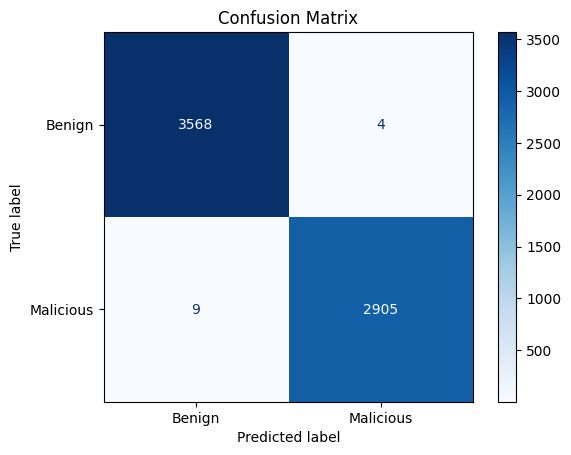

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels = ['Benign', 'Malicious'], cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.show()

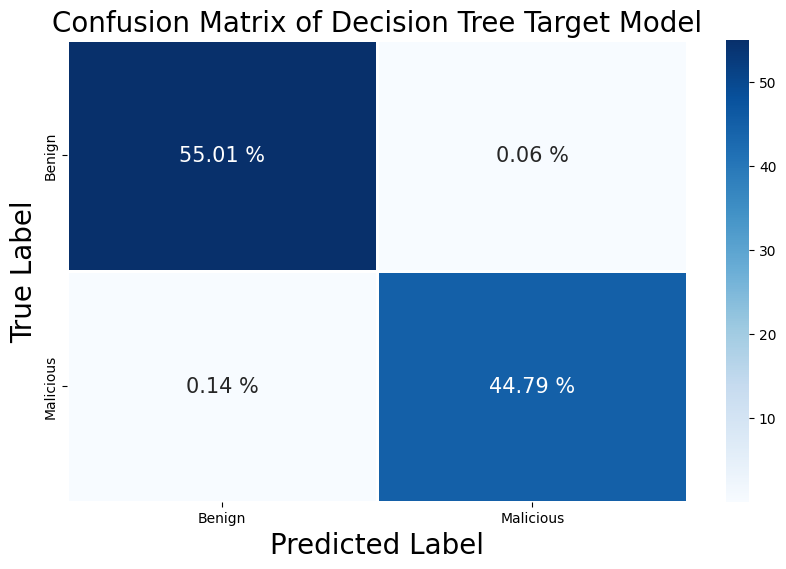

In [19]:
cm = confusion_matrix(y_test, y_pred_dt, labels=model_dt.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Decision Tree Target Model', fontsize=20)
plt.show()

### LogisticRegression

In [20]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)


LogisticRegression()

In [21]:
# Testing
lr_start_test = time.time()
y_pred_lr = model_lr.predict(X_test)
acc_test_lr = accuracy_score(y_test, y_pred_lr)
recall_score_test_lr = recall_score(y_test, y_pred_lr, average='weighted')
lr_end_test = time.time()
lr_testing_time = lr_end_test - lr_start_test


# Validation
lr_start_validation = time.time()
lr_y_val =  model_lr.predict(X_val)
lr_val_acc = accuracy_score(y_val, lr_y_val)
recall_score_val_lr = recall_score(y_val, lr_y_val, average='weighted')
lr_end_validation = time.time()
lr_validation_time = lr_end_validation - lr_start_validation

# Results
print("Logistic Regression")
print("Accuracy: ", acc_test_lr)
print("Recall: ", recall_score_test_lr)
print("Validation Accuracy: ", lr_val_acc)
print("Validation Recall: ", recall_score_val_lr)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_lr))
print("Classification report: \n", classification_report(y_test, y_pred_lr, target_names=['Benign', 'Malicious'], digits=4))

Logistic Regression
Accuracy:  0.7246376811594203
Recall:  0.7246376811594203
Validation Accuracy:  0.7213872832369942
Validation Recall:  0.7213872832369942
Confusion matrix: 
 [[3237  335]
 [1451 1463]]
Classification report: 
               precision    recall  f1-score   support

      Benign     0.6905    0.9062    0.7838      3572
   Malicious     0.8137    0.5021    0.6210      2914

    accuracy                         0.7246      6486
   macro avg     0.7521    0.7041    0.7024      6486
weighted avg     0.7458    0.7246    0.7106      6486



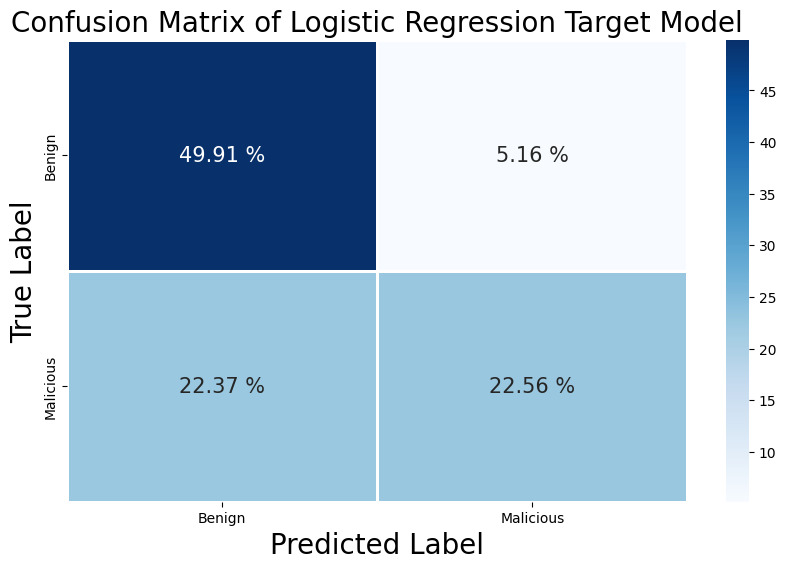

In [22]:
cm = confusion_matrix(y_test, y_pred_lr, labels=model_lr.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Logistic Regression Target Model', fontsize=20)
plt.show()

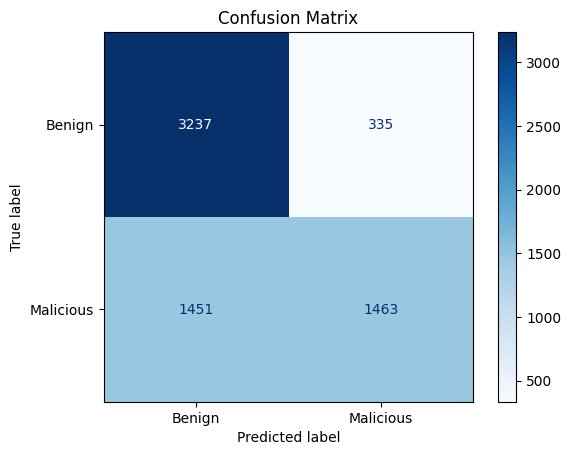

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, display_labels = ['Benign', 'Malicious'], cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix')
plt.show()

### randomforest

In [24]:
from sklearn.ensemble import RandomForestClassifier

# Training
randomforest_start_train = time.time()
model_randomforest = RandomForestClassifier(n_estimators=100,n_jobs = -1,random_state =50, min_samples_leaf = 10)

model_randomforest.fit(X_train, y_train)
randomforest_end_train = time.time()
randomforest_training_time = randomforest_end_train - randomforest_start_train

# Testing
randomforest_start_test = time.time()
y_pred_randomforest = model_randomforest.predict(X_test)
acc_test_randomforest = accuracy_score(y_test, y_pred_randomforest)
recall_score_test_randomforest = recall_score(y_test, y_pred_randomforest, average='weighted')
randomforest_end_test = time.time()
randomforest_testing_time = randomforest_end_test - randomforest_start_test


# Validation
randomforest_start_validation = time.time()
randomforest_y_val =  model_randomforest.predict(X_val)
randomforest_val_acc = accuracy_score(y_val, randomforest_y_val)
recall_score_val_randomforest = recall_score(y_val, randomforest_y_val, average='weighted')
randomforest_end_validation = time.time()
randomforest_validation_time = randomforest_end_validation - randomforest_start_validation

# Results
print("randomforest Classifier")
print("Accuracy: ", acc_test_randomforest)
print("Recall: ", recall_score_test_randomforest)
print("Validation Accuracy: ", randomforest_val_acc)
print("Validation Recall: ", recall_score_val_randomforest)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_randomforest))
print("Classification report: \n", classification_report(y_test, y_pred_randomforest, target_names=['Benign', 'Malicious'], digits=4))

randomforest Classifier
Accuracy:  0.9912118408880666
Recall:  0.9912118408880666
Validation Accuracy:  0.9884393063583815
Validation Recall:  0.9884393063583815
Confusion matrix: 
 [[3526   46]
 [  11 2903]]
Classification report: 
               precision    recall  f1-score   support

      Benign     0.9969    0.9871    0.9920      3572
   Malicious     0.9844    0.9962    0.9903      2914

    accuracy                         0.9912      6486
   macro avg     0.9906    0.9917    0.9911      6486
weighted avg     0.9913    0.9912    0.9912      6486



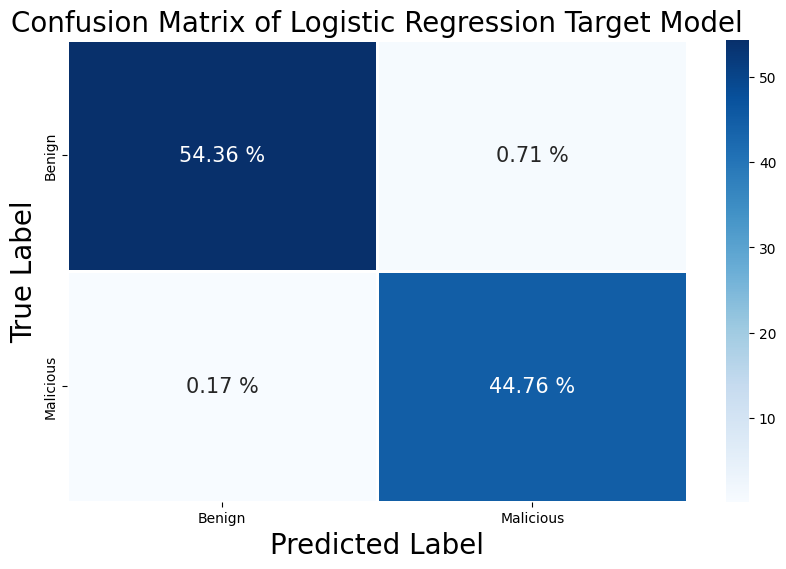

In [25]:
cm = confusion_matrix(y_test, y_pred_randomforest, labels=model_randomforest.classes_)
total = np.sum(cm)
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'], annot_kws={"size": 15})
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Logistic Regression Target Model', fontsize=20)
plt.show()

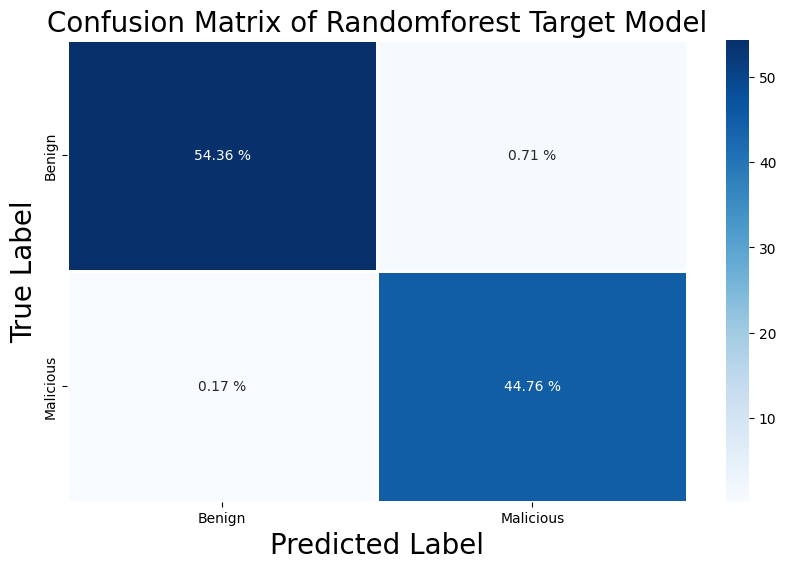

In [26]:
cm = confusion_matrix(y_test, y_pred_randomforest, labels=model_randomforest.classes_)
total = np.sum(cm )
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of Randomforest Target Model', fontsize=20)
plt.show()

### Xgboost

In [27]:
# import torch
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report

# Training
xgb_start_train = time.time()
model_xgb = xgb.XGBClassifier(
    early_stopping_rounds=10,
    # device = device
)

# cupy_X_train = cupy.array(X_train)
# cupy_X_test = cupy.array(X_test)
# cupy_X_val = cupy.array(X_val)
# cupy_y_train = cupy.array(y_train)
# cupy_y_test = cupy.array(y_test)
# cupy_y_val = cupy.array(y_val)

model_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_end_train = time.time()
xgb_training_time = xgb_end_train - xgb_start_train

In [28]:
# Testing
xgb_start_test = time.time()
y_pred_xgb = model_xgb.predict(X_test)
acc_test_xgb = accuracy_score(y_test, y_pred_xgb)
recall_score_test_xgb = recall_score(y_test, y_pred_xgb, average='weighted')
xgb_end_test = time.time()
xgb_testing_time = xgb_end_test - xgb_start_test


# Validation
xgb_start_validation = time.time()
xgb_y_val =  model_xgb.predict(X_val)
xgb_val_acc = accuracy_score(y_val, xgb_y_val)
recall_score_val_xgb = recall_score(y_val, xgb_y_val, average='weighted')
xgb_end_validation = time.time()
xgb_validation_time = xgb_end_validation - xgb_start_validation

# Results
print("XGBoost Classifier")
print("Accuracy: ", acc_test_xgb)
print("Recall: ", recall_score_test_xgb)
print("Validation Accuracy: ", xgb_val_acc)
print("Validation Recall: ", recall_score_val_xgb)
print("Confusion matrix: \n", confusion_matrix(y_test, y_pred_xgb))
print("Classification report: \n", classification_report(y_test, y_pred_xgb, target_names=['Benign', 'Malicious'], digits=4))

XGBoost Classifier
Accuracy:  0.9728646315140302
Recall:  0.9728646315140302
Validation Accuracy:  0.9907514450867052
Validation Recall:  0.9907514450867052
Confusion matrix: 
 [[3568    4]
 [ 172 2742]]
Classification report: 
               precision    recall  f1-score   support

      Benign     0.9540    0.9989    0.9759      3572
   Malicious     0.9985    0.9410    0.9689      2914

    accuracy                         0.9729      6486
   macro avg     0.9763    0.9699    0.9724      6486
weighted avg     0.9740    0.9729    0.9728      6486



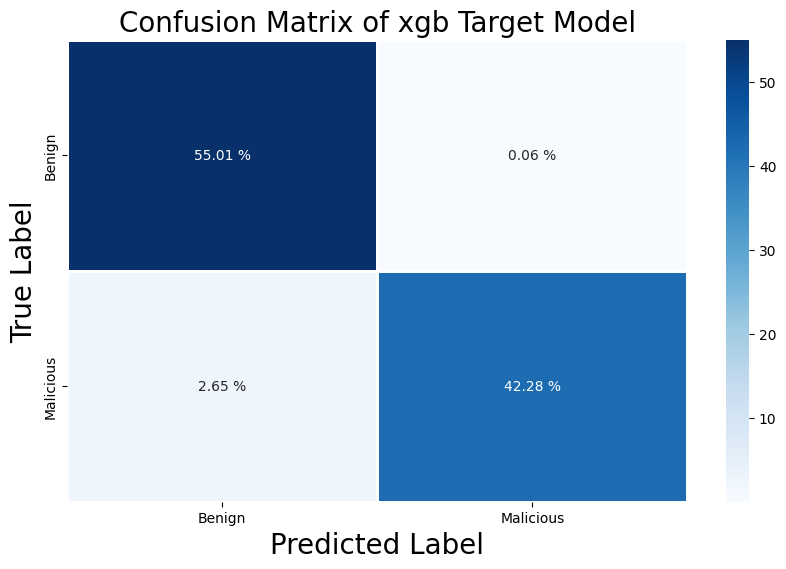

In [29]:
cm = confusion_matrix(y_test, y_pred_xgb, labels=model_xgb.classes_)
total = np.sum(cm )
confusion_percentage = (cm  / total) * 100

strings = np.asarray([['%', '%'],
                    ['%', '%']])
labels = (np.asarray(["{1:.2f} %".format(string, confusion_percentage) for string, confusion_percentage in zip(strings.flatten(), confusion_percentage.flatten())])).reshape(2, 2)
plt.figure(figsize=(10,6))
sns.heatmap(confusion_percentage, annot=labels, fmt='', cmap=plt.cm.Blues, linewidths=1, xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.title('Confusion Matrix of xgb Target Model', fontsize=20)
plt.show()

### Save Model

In [30]:
import torch
import pickle

# save model
pickle.dump(model_dt, open("../target_model/ml_model/CICIDS2018target_dt.pickle", "wb")) # target_model\ml_model
pickle.dump(model_randomforest, open("../target_model/ml_model/CICIDS2018target_randomforest.pickle", "wb"))
pickle.dump(model_xgb, open("../target_model/ml_model/CICIDS2018target_xgb.pickle", "wb"))
pickle.dump(model_lr, open("../target_model/ml_model/CICIDS2018target_lr.pickle", "wb"))
# torch.save(model_dt.state_dict(), 'target/ml_model/model_dt.pth')
# torch.save(model_lr.state_dict(), 'target/ml_model/model_lr.pth')